# How to use Azure to do Style Transfer on a Video

This tutorial will take you through how to take a video, and apply style transfer onto every frame of the video, using Azure.

Inside __/pytorch/images__, you should find a __/style_images__ folder and a __/sample_content_images__ folder.

- Inside the __/style_images__ folder is an image of Vangogh painting (titled, __sample_vangogh.jpg__) that we will be using as our sample style image. 
- Inside the __/sample_content_images__ folder, which we will use solely for the purposes of testing locally, there are 4 sample images that we will use to apply the style onto. (images are titled, __sample_%1.jpg__)

The interactive notebook (__style_transfer_interactive.ipynb__) and the script (__style_transfer_script.py__) will using the above directories.

## (Optional) Tuning the style transfer hyperparameters interactively

The first thing we want to do is to test the style transfer scripts locally and make sure the hyper parameters are set appropriately. This will be done using the __style_transfer_interactive.ipynb__ notebook.

Open the notebook __/pytorch/style_transfer_interactive.ipynb__ and tune the variables following variables as desired: 

- STYLE_WEIGHT = 10**8
- CONTENT_WEIGHT = 10**0
- NUM_STEPS = 100

*the defaults shown above _tend_ to work nicely for most images.

## Testing the style transfer script locally

Lets make sure that our style transfer script is running correctly on our local machine. First we need to create the directory to store the output images.

In [40]:
%%bash
mkdir pytorch/images/sample_output_images

If you changed the hyperparameters in the above section and would like to apply it, you can use the following variables: `--style-weight`, `--content-weight`, and/or `--num-steps`

In [1]:
%%bash
cd pytorch &&
    python style_transfer_script.py \
    --style-image ./images/style_images/sample_renior.jpg \
    --content-image-dir ./images/sample_content_images \
    --content-image-list 'sample_0.jpg' \
    --output-image-dir ./images/sample_output_images \
    --style-weight $STYLE_WEIGHT \
    --content-weight $CONTENT_WEIGHT \
    --num-steps $NUM_STEPS \
    --image-size $IMAGE_SIZE \
    --log-file 'sample_style_transfer_script'

2018-08-30 02:07:25,592 - __main__ - DEBUG - Images to process: 1
2018-08-30 02:07:25,592 - __main__ - DEBUG - GPU detected: True, image size: 360
2018-08-30 02:07:28,956 - __main__ - DEBUG - Time (in seconds) to load style image: 3.362901
2018-08-30 02:07:30,558 - __main__ - DEBUG - Time (in seconds) to load VGG19 model: 1.602304
2018-08-30 02:07:30,608 - __main__ - DEBUG - Running Style Transfer on sample_0.jpg
2018-08-30 02:07:43,211 - __main__ - DEBUG - Time (in seconds) to apply style-transfer to batch of 1 images: 12.652457
2018-08-30 02:07:43,211 - __main__ - DEBUG - Average Time (in seconds) to apply style-transfer to each image: 12.652457


We can now inspect the output directory to make sure that the output images are there.

In [2]:
%%bash
ls pytorch/images/sample_output_images

sample_0.jpg
sample_1.jpg
sample_2.jpg
sample_3.jpg


Lets see what one of those images look like:

![sample_0](pytorch/images/sample_output_images/sample_0.jpg)

## Setup your video for batch style transfer

### Download Video: 

The first thing we need to do is to download a video that we would like to apply style transfer onto. To do so, we'll download a short climbing video that I preloaded into a public Blob Storage.

*Feel free to manually place your own video (mp4) file into that directory instead of downloading the climbing video...

In [4]:
%%bash
mkdir pytorch/video

In [10]:
%set_env VIDEO_NAME=orangutan

env: VIDEO_NAME=orangutan


In [3]:
%%bash
cd pytorch/video && 
    wget https://happypathspublic.blob.core.windows.net/videos/${VIDEO_NAME}.mp4

--2018-08-29 14:53:12--  https://happypathspublic.blob.core.windows.net/videos/orangutan.mp4
Resolving happypathspublic.blob.core.windows.net (happypathspublic.blob.core.windows.net)... 52.239.214.164
Connecting to happypathspublic.blob.core.windows.net (happypathspublic.blob.core.windows.net)|52.239.214.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7961293 (7.6M) [video/mp4]
Saving to: ‘orangutan.mp4’

     0K .......... .......... .......... .......... ..........  0% 4.68M 2s
    50K .......... .......... .......... .......... ..........  1% 4.66M 2s
   100K .......... .......... .......... .......... ..........  1% 9.23M 1s
   150K .......... .......... .......... .......... ..........  2% 9.16M 1s
   200K .......... .......... .......... .......... ..........  3%  242M 1s
   250K .......... .......... .......... .......... ..........  3% 9.36M 1s
   300K .......... .......... .......... .......... ..........  4% 9.90M 1s
   350K .......... ..........

Lets check out the video so we know what it looks like before hand:

In [35]:
from IPython.display import HTML
import os
HTML('\
    <video width="360" height="360" controls> \
         <source src="pytorch/video/{0}.mp4" type="video/mp4"> \
    </video>'\
    .format(os.getenv('VIDEO_NAME'))
)

### Pre-process video with ffmpeg

Next we need to use __ffmpeg__ to extract the audio file, which we will save as __chicken.aac__ under the video directory.

In [36]:
%%bash 
cd pytorch/video &&
    ffmpeg -i ${VIDEO_NAME}.mp4 ${VIDEO_NAME}.mp3

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

Finally, we need break up the frames of the video into separate individual images. The images will be saved inside a new folder under the images directory, called __chicken_frames__.

In [37]:
%%bash
cd pytorch/images/ &&
    mkdir ${VIDEO_NAME} && cd ${VIDEO_NAME} &&
    ffmpeg -i ../../video/${VIDEO_NAME}.mp4 %05d_${VIDEO_NAME}.jpg -hide_banner

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '../../video/orangutan.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.12.100
  Duration: 00:00:27.48, start: 0.021333, bitrate: 2317 kb/s
    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p, 720x720, 2242 kb/s, 30 fps, 30 tbr, 15360 tbn, 60 tbc (default)
    Metadata:
      handler_name    : VideoHandler
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, mono, fltp, 69 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
[swscaler @ 0xb18780] deprecated pixel format used, make sure you did set range correctly
Output #0, image2, to '%05d_orangutan.jpg':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf56.40.101
    Stream #0:0(und): Video: mjpeg, yuvj420p(pc), 720x720, q=2-31, 200 kb/s, 30 fps, 30 tbn, 30 tbc (default)
    Meta

We can count the number of frames that the video produced:

In [38]:
%%bash
cd pytorch/images/${VIDEO_NAME} && ls -1 | wc -l

824


At this point, our file system should have the following under the folder __pytorch_style_transfer__:
```md
├── images/
│   ├── video_name/ [<--new dir with video frames as images]
│   ├── sample_content_images/
│   ├── sample_output_images/
│   └── style_images/
├── video/
│   ├── video_name.mp4 [<--new video]
│   └── video_name.mp3 [<--new extracted audio file for video]
├── style_transfer_interactive.ipynb
└── style_transfer_script.py
```

Now that we have all the frames of the video stored seperately as images, we are ready to scale out and try scoring in the cloud.

## Testing our Style Transfer Script on Azure BatchAI

In this tutorial, we use Azure BatchAI to scale out of computation to multiple GPUs in Azure.

### Setting up your cluster

First, we need to create your cluster using the __azure/scripts/create_cluster.py__ script.

This script will create the BatchAI workspace for all BatchAI resources to be created in.

After running this command, go into the Azure portal and check that your cluster is successfully created.

In [43]:
%%bash 
python azure/scripts/create_cluster.py

Cluster state: steady; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0


Keyring cache token has failed: No recommended backend was available. Install the keyrings.alt package if you want to use the non-recommended backends. See README.rst for details.


### Upload files into Azure Blob Storage

Now we need to upload the script and model files to the fileshare using __az_copy__. We'll also upload our content images to test our Batch AI jobs. 

After running this command, go into the Azure portal or the Azure Storage Explorer and make sure that the files are correctly uploaded.

In [47]:
%%bash
azcopy \
    --source pytorch/style_transfer_script.py \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/${FS_INPUT_DIR}/${FS_SCRIPT_NAME} \
    --dest-key $STORAGE_ACCOUNT_KEY
    
azcopy \
    --source pytorch/images/style_images/sample_renior.jpg \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/${FS_INPUT_DIR}/${FS_STYLE_IMG_NAME} \
    --dest-key $STORAGE_ACCOUNT_KEY
    
azcopy \
    --source pytorch/images/${VIDEO_NAME} \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/${FS_CONTENT_DIR} \
    --dest-key $STORAGE_ACCOUNT_KEY \
    --recursive

[2018/08/29 15:26:12] Transfer summary:
-----------------
Total files transferred: 1
Transfer successfully:   1
Transfer skipped:        0
Transfer failed:         0
Elapsed time:            00.00:00:00
[2018/08/29 15:26:13] Transfer summary:
-----------------
Total files transferred: 1
Transfer successfully:   1
Transfer skipped:        0
Transfer failed:         0
Elapsed time:            00.00:00:00
[2018/08/29 15:26:15] Transfer summary:
-----------------
Total files transferred: 824
Transfer successfully:   824
Transfer skipped:        0
Transfer failed:         0
Elapsed time:            00.00:00:01


### Create a Test job

Finally, lets test that our style transfer script works on the Batch AI cluster. Use the __azure/scripts/create_job.py__ script to kick off a job. 

Kicking off this job will also automatically create 2 additional folders in your Blob container. The first folder will be named __output_of_content_YYYY_MM_DD_HHMMSS__ and the second will be named __logs_of_content_YYYY_MM_DD_HHMMSS__. The style transfer script will automatically save all output of the style transfer to the first folder. And likewise, all logs collected from the style transfer script will be saved to the second folder.

NOTE - this command could take a while to execute. Remember that this will apply style transfer onto each frame of the video - this means that the code will optimize the style transfer loss function for every frame. 

After running this command, go into the Azure portal under your BatchAI account to make sure the job is sucessfully created.

In [1]:
%%bash
python azure/scripts/create_job.py --job-batch-size 50

2018-08-30 14:53:35,458 - __main__ - DEBUG - Created job #0, named job0_08_30_2018_145318, with 50 images.
2018-08-30 14:53:52,893 - __main__ - DEBUG - Created job #1, named job1_08_30_2018_145335, with 50 images.
2018-08-30 14:54:10,134 - __main__ - DEBUG - Created job #2, named job2_08_30_2018_145352, with 50 images.
2018-08-30 14:54:26,902 - __main__ - DEBUG - Created job #3, named job3_08_30_2018_145410, with 50 images.
2018-08-30 14:54:43,536 - __main__ - DEBUG - Created job #4, named job4_08_30_2018_145426, with 50 images.
2018-08-30 14:55:00,072 - __main__ - DEBUG - Created job #5, named job5_08_30_2018_145443, with 50 images.
2018-08-30 14:55:17,557 - __main__ - DEBUG - Created job #6, named job6_08_30_2018_145500, with 50 images.
2018-08-30 14:55:34,928 - __main__ - DEBUG - Created job #7, named job7_08_30_2018_145517, with 50 images.
2018-08-30 14:55:52,037 - __main__ - DEBUG - Created job #8, named job8_08_30_2018_145534, with 50 images.
2018-08-30 14:56:09,161 - __main__ - 

Keyring cache token has failed: No recommended backend was available. Install the keyrings.alt package if you want to use the non-recommended backends. See README.rst for details.


### Inspect the results

When the jobs finish running, you can use the Azure portal or Storage explorer to inspect the output images.

Inside your Blob Container, you should notice that a new directory with the datetime-stamp is created. Output images are stored there.

## Running it with Docker

After we've tested that the BatchAI jobs are successfully created, we now want to build a docker container and check that we can run the BatchAI job from a docker container.

First we need to build the docker image using the Dockerfile which will upload all Azure utility python files as well as the __create_job.py__ file into the image.

In [1]:
%%bash
cd azure &&
    sudo docker build -t $DOCKER_IMAGE .


Step 1/7 : FROM python:3.6-jessie
 ---> 11aa3556fb90
Step 2/7 : WORKDIR /job
 ---> Using cache
 ---> 35f724c2aa53
Step 3/7 : ADD scripts/create_job.py /job
 ---> Using cache
 ---> cb3babc14069
Step 4/7 : ADD scripts/util /job/util
 ---> Using cache
 ---> 43d4b320c76d
Step 5/7 : ADD requirements.txt /job
 ---> Using cache
 ---> 48640f43f1c6
Step 6/7 : RUN pip install --trusted-host pypi.python.org -r requirements.txt
 ---> Using cache
 ---> c3e9bc9ef833
Step 7/7 : CMD ["python", "create_job.py"]
 ---> Using cache
 ---> 738694a2db9f
Successfully built 738694a2db9f
Successfully tagged bai_job:latest


[Optional] 

Then we test that the BatchAI job can be executed from the docker image we just built. Because the __create_job.py__ file requires many environment variables, we will use the __docker_run.sh__ script to pass in all the required environment variables for the image to successfully run locally. This step is optional as it will take several minutes to run the job.

In [2]:
%%bash
cd azure &&
    source docker_run.sh -t $DOCKER_IMAGE

2018-08-29 15:46:46,734 - __main__ - DEBUG - Created job #0, named job0_08_29_2018_154630, with 50 images.
2018-08-29 15:47:03,115 - __main__ - DEBUG - Created job #1, named job1_08_29_2018_154646, with 50 images.
2018-08-29 15:47:19,406 - __main__ - DEBUG - Created job #2, named job2_08_29_2018_154703, with 50 images.
2018-08-29 15:47:35,750 - __main__ - DEBUG - Created job #3, named job3_08_29_2018_154719, with 50 images.
2018-08-29 15:47:52,325 - __main__ - DEBUG - Created job #4, named job4_08_29_2018_154735, with 50 images.
2018-08-29 15:48:08,556 - __main__ - DEBUG - Created job #5, named job5_08_29_2018_154752, with 50 images.
2018-08-29 15:48:24,834 - __main__ - DEBUG - Created job #6, named job6_08_29_2018_154808, with 50 images.
2018-08-29 15:48:40,991 - __main__ - DEBUG - Created job #7, named job7_08_29_2018_154824, with 50 images.
2018-08-29 15:48:57,315 - __main__ - DEBUG - Created job #8, named job8_08_29_2018_154840, with 50 images.
2018-08-29 15:49:13,512 - __main__ - 

Finally, we have to publish the image to Dockerhub. _Make sure you replace <your-dockerhub-username>_ with your Dockerhub username. Don't forget that you'll have to make sure you're already logged in before being able to push your image up. (`docker login`)

In [6]:
%%bash
cd azure &&
    sudo docker tag bai_job $DOCKER_USER/$DOCKER_IMAGE &&
    sudo docker push $DOCKER_USER/$DOCKER_IMAGE

The push refers to repository [docker.io/jiata/bai_job]
5aa5e8885385: Preparing
bb4ed76240f9: Preparing
62efca09342b: Preparing
492c5cd0a446: Preparing
6aca85ba2c1f: Preparing
0c5d1b2a1642: Preparing
66a1aa763275: Preparing
6db858a45525: Preparing
1385e3b82428: Preparing
f3693db46abb: Preparing
bb6d734b467e: Preparing
5f349fdc9028: Preparing
2c833f307fd8: Preparing
0c5d1b2a1642: Waiting
66a1aa763275: Waiting
6db858a45525: Waiting
1385e3b82428: Waiting
f3693db46abb: Waiting
bb6d734b467e: Waiting
5f349fdc9028: Waiting
2c833f307fd8: Waiting
6aca85ba2c1f: Layer already exists
0c5d1b2a1642: Layer already exists
66a1aa763275: Layer already exists
bb4ed76240f9: Pushed
492c5cd0a446: Pushed
1385e3b82428: Layer already exists
6db858a45525: Layer already exists
bb6d734b467e: Layer already exists
5f349fdc9028: Layer already exists
62efca09342b: Pushed
2c833f307fd8: Layer already exists
f3693db46abb: Layer already exists
5aa5e8885385: Pushed
latest: digest: sha256:1af3cf3413738fc0a3875fa0a67029faa8

## Setting up ACI with Logic Apps

First we need to generate the ARM deployment template for deploying ACI and Logic App to set up the trigger. We will use the __generate_trigger_arm.py__ script to generate an ARM Template (JSON) which we can use to deploy the ACI and Logic App. The script uses __azure/deployments/template.trigger_arm.json__ to generate __azure/deployments/trigger_arm.json__, which we can use to execute the deployment.

If you inspect the ARM Template, you'll see that Logic App will be triggered when a new file is added to the blob. The trigger will only occur if the blob filename begins with 'trigger' and ends with '.txt'. It will then use the contents of the blob to look for the corresponding directory in that Blob Container, which it then uses as the content image file directory for the transfer.

For example, if we upload a file, titled `trigger_0.txt`, with the content "content_image_dir", the Logic App will look for a directory in the Blob Container titled "content_image_dir", and start to process the images it finds in the directory.

First lets generate the trigger template:

In [1]:
%%bash
cd azure/arm &&
    python ../scripts/generate_trigger_arm.py trigger_arm.json

Now lets use the __az cli__ to deploy the solution.

In [2]:
%%bash
az group deployment create \
    --name aci_logicapp_deployment \
    --resource-group $RESOURCE_GROUP \
    --template-file azure/arm/trigger_arm.json

{
  "id": "/subscriptions/0ca618d2-22a8-413a-96d0-0f1b531129c3/resourceGroups/js_batch_scoring_dl/providers/Microsoft.Resources/deployments/aci_logicapp_deployment",
  "name": "aci_logicapp_deployment",
  "properties": {
    "correlationId": "4e304069-d67a-4451-8d60-f27c2ce2696f",
    "debugSetting": null,
    "dependencies": [
      {
        "dependsOn": [
          {
            "id": "/subscriptions/0ca618d2-22a8-413a-96d0-0f1b531129c3/resourceGroups/js_batch_scoring_dl/providers/Microsoft.Web/connections/aci",
            "resourceGroup": "js_batch_scoring_dl",
            "resourceName": "aci",
            "resourceType": "Microsoft.Web/connections"
          },
          {
            "id": "/subscriptions/0ca618d2-22a8-413a-96d0-0f1b531129c3/resourceGroups/js_batch_scoring_dl/providers/Microsoft.Web/connections/azureblob",
            "resourceGroup": "js_batch_scoring_dl",
            "resourceName": "azureblob",
            "resourceType": "Microsoft.Web/connections"
        

## Trigger the process

Finally we need to trigger the process by loading something into blob. Normally, this can be done with any process (such as drag-and-drop using Storage Explorer), but for the purposes of this demo, lets do so simply with __az_copy__.

First we create a file, __foo.txt__ with the contents being the name of the directory in the blob that we want to apply style transfer too.

In [ ]:
%%bash
touch trigger_0.txt &&
    echo $FS_CONTENT_DIR > trigger_0.txt

Next we have to copy that file over to storage to trigger the process:

In [ ]:
%%bash
azcopy \
    --source trigger_0.txt \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/trigger_0.txt \
    --dest-key $STORAGE_ACCOUNT_KEY

We can now inspect the logs from ACI to see that everything is going smoothly:

In [3]:
%%bash
az container logs --resource-group $RESOURCE_GROUP --name $ACI_CONTAINER_GROUP

2018-08-28 20:41:36,072 - __main__ - DEBUG - Created job #0, named job0_08_28_2018_204119, with 50 images.
2018-08-28 20:41:51,572 - __main__ - DEBUG - Created job #1, named job1_08_28_2018_204136, with 50 images.
2018-08-28 20:42:07,071 - __main__ - DEBUG - Created job #2, named job2_08_28_2018_204151, with 50 images.
2018-08-28 20:42:22,452 - __main__ - DEBUG - Created job #3, named job3_08_28_2018_204207, with 50 images.
2018-08-28 20:42:38,060 - __main__ - DEBUG - Created job #4, named job4_08_28_2018_204222, with 50 images.
2018-08-28 20:42:53,460 - __main__ - DEBUG - Created job #5, named job5_08_28_2018_204238, with 50 images.
2018-08-28 20:43:09,286 - __main__ - DEBUG - Created job #6, named job6_08_28_2018_204253, with 50 images.
2018-08-28 20:43:24,677 - __main__ - DEBUG - Created job #7, named job7_08_28_2018_204309, with 50 images.
2018-08-28 20:43:40,069 - __main__ - DEBUG - Created job #8, named job8_08_28_2018_204324, with 50 images.
2018-08-28 20:43:55,702 - __main__ - 

At this point, we can inspect the Azure portal to see all the moving parts:
- Logic Apps will be triggers and will spin up ACI
- ACI will break up the content images in blob and create BatchAI jobs
- The BatchAI cluster will scale up and start processing the work
- As the style transfer script is executed in batch on BatchAI, we will see the completed images (as well as logs) saved back to blob 

## Download Results and Re-stitch Video

The last step is to download and restitch the video so that we can enjoy the same video, but now with each frame with style transfer applied.

First we need to get the name of the output folder where all out style transfered frames are stored. We do this by using the Batch AI CLI. We store the name of the output folder as `output_folder_name` to be used in later cells.

In [3]:
import os

# We use `--query [-1].name` to mean: 'get the name of the last experiment'
exp_names = !az batchai experiment list -g ${RESOURCE_GROUP} --workspace ${WORKSPACE} --query [-1].name

# strip quotation marks
exp_name = str(exp_names[0])[1:-1]

# replace experiment prefix with output folder prefix
exp_name_array = str(exp_name).split('_')
exp_name_array[0] = "{0}_{1}".format(os.getenv('FS_OUTPUT_DIR_PREFIX'), os.getenv('FS_CONTENT_DIR'))
output_folder_name = '_'.join(exp_name_array)

Using the `output_folder_name` variable, lets download the frames:

In [4]:
%%script env output_folder_name="$output_folder_name" bash
cd pytorch/images &&
    azcopy \
        --source https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME} \
        --destination . \
        --source-key $STORAGE_ACCOUNT_KEY \
        --include $output_folder_name \
        --recursive

[2018/08/29 15:55:37] Transfer summary:
-----------------
Total files transferred: 825
Transfer successfully:   825
Transfer skipped:        0
Transfer failed:         0
Elapsed time:            00.00:00:01


Then lets use ffmpeg to stitch independent frames back into a video.

In [12]:
%%script env output_folder_name="$output_folder_name" bash
cd pytorch &&
    ffmpeg \
        -framerate 30 \
        -i images/$output_folder_name/%05d_${VIDEO_NAME}.jpg \
        -c:v libx264 \
        -profile:v high -crf 20 -pix_fmt yuv420p \
        -y \
        video/${VIDEO_NAME}_processed_without_audio.mp4 

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [13]:
%%bash
cd pytorch/video &&
    ffmpeg -i ${VIDEO_NAMEVIDEO_NAME}_processed_without_audio.mp4 -i ${VIDEO_NAME}.mp3 \
        -map 0:0 -map 1:0 \
        -vcodec copy -acodec copy \
        -y \
        ${VIDEO_NAME}_processed_with_audio.mp4

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [15]:
from IPython.display import HTML
import os
HTML('\
    <video width="360" height="360" controls> \
         <source src="pytorch/video/{0}_processed_with_audio.mp4" type="video/mp4"> \
    </video>'\
    .format(os.getenv('VIDEO_NAME'))
)

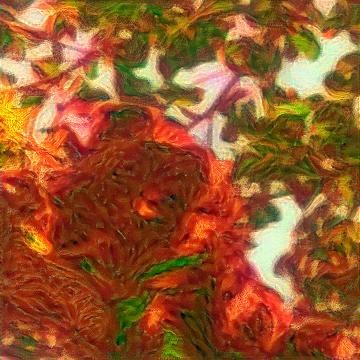

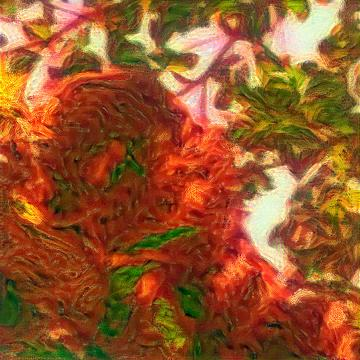

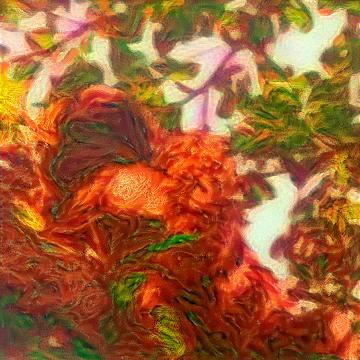

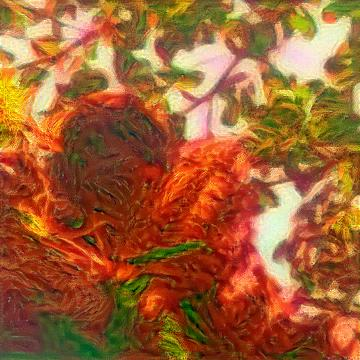

In [18]:
from IPython.display import Image
import os
im1 = Image(filename="pytorch/images/{0}/00001_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
im2 = Image(filename="pytorch/images/{0}/00100_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
im3 = Image(filename="pytorch/images/{0}/00300_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
im4 = Image(filename="pytorch/images/{0}/00500_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
display(im1, im2, im3, im4)

## Delete resources

Its always good to clean up your Azure resources after you've completed your workload.

In [ ]:
%%bash
az group delete --name $RESOURCE_GROUP